In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yaml

from utils import tf
from utils import probability_to_boolean

In [2]:
df_predictions_iql = pd.read_csv("../data/predictions.csv")
df_predictions_glm = pd.read_csv("../data/predictions-glm.csv")

df_test = pd.read_csv("../data/test.csv")

assert df_predictions_iql.shape == df_predictions_glm.shape
assert df_predictions_iql.shape[0] == df_test.shape[0]

In [3]:
def compute_probability_error_per_state(state, target, df_predictions, df_test):
    df_test_state = df_test[df_test.state==state]
    df_predictions_state = df_predictions[df_test.state==state]
    p_true = np.mean(df_test_state[target]=="yes")
    p_predicted = np.mean(df_predictions_state[target])
    return np.abs(p_true - p_predicted)

In [4]:
def aggregate_error_over_states(target, df_test, df_predictions_iql, df_predictions_glm):
    # Deal with the fact that the ground truth could be missing
    df_test = df_test[~df_test[target].isnull()]
    df_predictions_iql = df_predictions_iql.loc[df_test.index]
    df_predictions_glm = df_predictions_glm.loc[df_test.index]

    result = {"State":[],"Accuracy":[], "Method":[]}
    for state in df_test.state.unique():
        # IQL
        result["Accuracy"].append(compute_probability_error_per_state(state, target, df_predictions_iql, df_test))
        result["State"].append(state)
        result["Method"].append("Poststratified via\nInferenceQL")
        # GLM
        result["Accuracy"].append(compute_probability_error_per_state(state, target, df_predictions_glm, df_test))
        result["State"].append(state)
        result["Method"].append("Poststratified via\nGLM")
    return pd.DataFrame(result)

In [5]:
mkdir -p figs/poststrat-probability-error

In [6]:
def plot_error(target, results_df):
    fig, ax = plt.subplots()
    sns.barplot(data=results_df, x="State", y="Accuracy", hue="Method", ax=ax)
    ax.legend(loc="upper center", title="Method", ncol=3)
    ax.set_ylim(0.,0.14)
    ax.set_xlabel("State", fontweight="bold")
    ax.set_ylabel("Absolute Error", fontweight="bold", rotation=0, ha="right")
    fig.set_size_inches(7,4.5)
    fig.set_tight_layout(True)
    ax.set_title(f"Postratisfying column: {target}", fontweight="bold")
    fig.savefig(f"figs/poststrat-probability-error/post-strat-{target}.png", dpi=300)

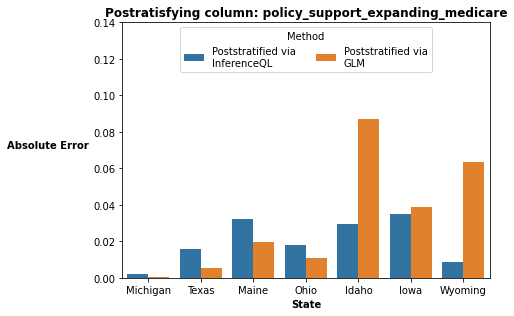

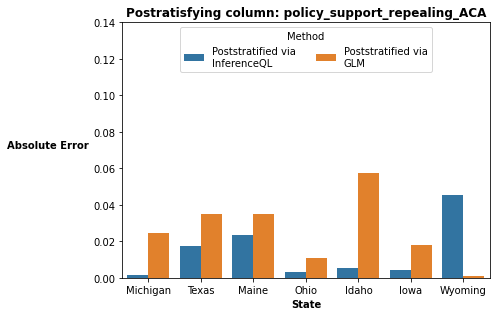

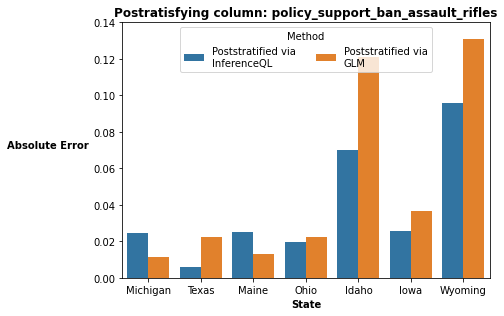

In [7]:
for target in df_predictions_iql.columns:
    results_df = aggregate_error_over_states(target, df_test, df_predictions_iql, df_predictions_glm)
    plot_error(target, results_df)